# Hamiltonian 
**Heisenberg Hamiltonian (for chain)**: 


$$\mathcal{H}=  J\sum\limits_{i}^{N-1}\hat{S}_{i}\cdot\hat{S}_{i+1} = J\sum\limits_{i}^{N-1}H_{i,i+1}$$
We can also re-write the Hamiltonian as:
$$\mathcal{H}=J\sum_{i=1}^{N-1}
\hat{S}^z_i \hat{S}^z_{i+1} +
\frac{1}{2}\left[
\hat{S}^+_i \hat{S}^-_{i+1} +
\hat{S}^-_i \hat{S}^+_{i+1}
\right] = H_{d} + H_{od}
$$

# Basic Idea:

* Since the full ED becomes practically intractable with the exponential increase in Hilbert space size, lanczos method is an alternative where a systematic construction of a basis (Krylov space) set (typically $\sim 100, 200, ... $) is done. This newly created basis approximately projects the system into low-energy states. Since, the basis size doesn't scale exponentially,  this also allows to go for larger system sizes (e.g. 20, 24, ...). Lowest energy states contribute significantly only at low-temperatures. So, the lanczos gives the details of the system effectively at low-temperatures. 



# Lanczos theory (followed by implementation):

Important step that differs from full ED is in the entire lanczos diagonalization is the '**Construction of lanczos vectors' (say $\{ | \phi \rangle\}\equiv ( |\phi_0\rangle, |\phi_1\rangle, |\phi_2\rangle, |\phi_3\rangle,... )$)**


### Construction of Krylov space:
* Start with random trial state, say $|\psi_0\rangle$.

Example:

In [19]:
import numpy as np

# Make sure it is very random and dont forget to normalize.
psi_0 = np.random.rand(10) + 1j*np.random.rand(10)
psi_0 /= np.linalg.norm(psi_0)
print(psi_0)
print(np.linalg.norm(psi_0))

[0.13461341+0.09116818j 0.30199776+0.13380272j 0.29358189+0.2477375j
 0.02284561+0.02563659j 0.01339735+0.22423957j 0.25036316+0.26240266j
 0.2307558 +0.30466016j 0.28817526+0.28866023j 0.23985351+0.29992808j
 0.09409349+0.25483872j]
1.0


* continuation ..
    * \begin{equation} 1^{\text{st}} \text{ basis state:  }\quad |\phi_0\rangle = \frac{|\psi_0\rangle}{\tilde{N}}, \quad \tilde{N}_0 = \langle \psi_0 | \psi_0 \rangle \end{equation}.
    
    * \begin{equation} 2^{\text{nd}} \text{ basis state: }\quad |\phi_1\rangle = \frac{H|\psi_0\rangle - H_{00}|\psi_0\rangle}{\tilde{N}_1}\end{equation}

    \begin{equation}\quad\quad\quad\quad\quad\quad\quad \vdots\end{equation}

    * \begin{equation} n^{\text{th}} \text{ basis state: }\quad |\phi_{n+1}\rangle= \frac{H|\psi_n\rangle - H_{nn}|\psi_n\rangle - H_{n-1,n}|\psi_{n-1}\rangle}{\tilde{N}_{n+1}}\end{equation}



# Problem 1: Lanczos diagonalization in fixed magnetization ($M_z=0$) sector.
### Questions:
1. Show/plot the convergence of first four lowest energy states.
2. With and without reorthogonalization.
3. Compare with power ED, the groundstate energy value and the convergence plot of it.

In [20]:
# -*- coding: utf-8 -*
from __future__ import absolute_import, division, print_function
import itertools
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



def flip(l0, l1):         # Operation of flipping spins, lo, l1 = {-1,1}
    if (l0 == -1 and l1 == 1):
     return [[1, -1]]
    if (l0 == 1 and l1 == -1):
     return [[-1, 1]]

def basis_no(i,S):              # Convert spin configuration into appropriate index. Should be Bijective
    L=len(i)
    z=0
    for j in range(L):
        z += (S**j)*int((i[L-j-1]+1)/2)
    return z


def save(file,X,Y):
    np.savetxt(file, list(zip(X, Y)), fmt='%.12g')      # Save the file


def energy(T,W):       # Energy function, input is the eigenvalue matrix
    enrg=0
    Z=0
    for i in range(len(W)):
        Z       += np.exp(-(W[i])/T)           # Partition function
        enrg    += W[i]*np.exp(-W[i]/T)        # Energy ensemble average
    return (enrg/Z)  

def get_hamiltonian(L, J, s):
    S = int(round(2*s))+1    # Effective spin in the system
    nhil = S**L   # Hilbert space-dimension
    bonds = [[(i+j)%L for i in range(2)] for j in range(L)] # Array containing the interaction pairs
    H = np.zeros((nhil,nhil),dtype=np.float64) # Initialize the Hamiltonian Matrix
    for ii in itertools.product([-1,1], repeat=L): # Going through the Hilbert space loop
        diag_energy = 0     
        for bond in bonds: # Go through the bonds loop
            diag_energy+= -(J-J*(ii[bond[0]]*ii[bond[1]]))*s*s # Calculate the sum of diagonal matrix elements
            if ii[bond[0]] == ii[bond[1]]: # Parallel spins dont contribute to off-diaganal operator
               continue
            kk = flip(ii[bond[0]], ii[bond[1]]) # Flip and store the new config in kk
            for j in kk:
                jj = ii                
                jj = list(jj)
                jj[bond[0]]=j[0] 
                jj[bond[1]]=j[1] 
                jj = tuple(jj)

                H[basis_no(ii,S)][basis_no(jj,S)]=J*s
        H[basis_no(ii,S)][basis_no(ii,S)]=diag_energy
    return H 


def full_ED(L, J, s):
    X=[]
    Y=[]
    for T in np.arange(0.1,2.0,0.01):
        H = get_hamiltonian(L, J, s)
        W = sp.linalg.eigh(H, eigvals_only=True)
        e = energy(T,W)
        #print("Energy per spin at T =", T, "is,", e/L)
        X = np.append(X, np.array([T]))
        Y = np.append(Y, np.array([e/L]))
    save("enrg_"+str(J)+"_"+str(L)+".dat",list(X),list(Y)) 

In [21]:
import numpy as np

def lanczos(A, desired_rank, with_reorthogonalization=False):
    '''
    Note:  Works only for symmetric matrix
    Input:
        A: is a symmetrix sparse matrix (or a full matrix).
        desired_rank: No. of lowest eigen-values we wish to obtain.
    output:
        d: Eigen value matrix of triadiagonal matrix.
        s: Eigen vector matrix of tridiagonal matrix.
    '''
    desired_rank += 2

    # Some pre-requisite initializations
    n = A.shape[1] # get the shape of the matrix. And create the |psi_0> vector of the input matrix 'A' shape.
    v_next = np.random.rand(n)# + 1j*np.random.rand(linear_size)
    v_next /= np.linalg.norm(v_next)# Normalization of |psi_n>
    v_prev = np.zeros(n) # to store |psi_n-1>
    beta = np.zeros(desired_rank+1) # off diagonal elements corresponding to triadiagonal matrix setting to zero.
    beta[0] = 0
    alpha = np.zeros(desired_rank)# Diagonal elements corresponding to  to triadiagonal matrix
    
    
    # Initializing lists for storing the minimum eigen values. Will be used to plot versus No. of iterations.
    iters = []
    eigs0 = []
    eigs1 = []
    eigs2 = []
    eigs3 = []
    
    #storage of all the eigen vectors.
    V = np.zeros((n, desired_rank))
    
    # Iterative loop starts here. Construction of krylov basis.
    for i in range(desired_rank):
        
        # This step is the nth basis vector construction. Implementation of the above equation.
        w = A.dot(v_next)
        alpha[i] = np.dot(w, v_next)
        w = w - alpha[i] * v_next - beta[i] * v_prev
        beta[i+1] = np.linalg.norm(w) 
        v_prev = v_next
        v_next = w / beta[i+1]
        V[:, i] = v_prev
        #print(i,np.dot(V[:, i],V[:,0]))
        #print("Iterative eigenvector at iter,",i,V[:, i])
        #print(i,np.dot(V[:, i],v_next))
        
        # Crucial step inorder the eigen-vectors not to collapse. Removes the issue of loss of orthogonality.
        if with_reorthogonalization:
            # Full Orthogonalization:
            for t in range(i):
                tmp = np.dot(w, V[:, t])
                if abs(tmp) < 1e-10:
                    continue
                w -= tmp * V[:, t]
                beta[i+1] = np.linalg.norm(w) 
                V[:, i] = w / beta[i+1]
                
                #print("contributions from the new component,",w)
                #print("New normalized vector,",V[:,i])

    # Create tridiagonal matrix with size (desired_rank X desired_rank)  
    tridiag = np.diag(alpha)
    #print(tridiag)
    for i in range(0, desired_rank-1):
        tridiag[i, i+1] = beta[i+1] 
        tridiag[i+1, i] = beta[i+1]
        #if i < 1:
            #print(tridiag)
        d, v = np.linalg.eig(tridiag)
        iters.append(i)
        eigs0.append(d.min())
        eigs1.append(find_nminimum(d,1))
        eigs2.append(find_nminimum(d,2))
        eigs3.append(find_nminimum(d,3))
        
    # Get eigenvectors and eigenvalues of this tridiagonal matrix.  
    # The eigenvalues of this tridiagnoal matrix equals to the eigenvalues of matrix dot(A, A.T.). 
    # We can get the eigenvectors of dot(A, A.T) by multiplying V with eigenvectors of this tridiagonal matrix.
    d, v = np.linalg.eig(tridiag)
    #print(d,v)
    
    # Sort eigenvalues and their corresponding eigenvectors 
    sorted_idx = np.argsort(np.absolute(d))[::-1]
    d = d[sorted_idx]
    v = v[:, sorted_idx]
  
    # Get the eigenvetors of dot(A, A.T)
    s = np.dot(V, v)
    
    return d[0:desired_rank-2], s[:, 0:desired_rank-2], iters, eigs0, eigs1, eigs2, eigs3 

In [22]:
from __future__ import absolute_import, division, print_function
import numpy as np
import scipy 
import scipy.sparse
import matplotlib.pyplot as plt



def IBITS(n,i):
    return ((n >> i) & 1)

def mag_basis(L, Nup):
    dim = 0
    nhil = 2**L
    basis = []
    for state in range(nhil):
        n_ones = 0
        for bit in range(L):
            n_ones += IBITS(state,bit)
        if(n_ones == Nup):
            basis.append(state)
            dim += 1
    return basis, dim

def get_mag_sub_hamiltonian(L, J):
    basis, nred = mag_basis(L, L/2)
    bonds = [[(i+j)%L for i in range(2)] for j in range(L)]
    #print(bonds)
    H = []; R = []; C = []
    for i in range(nred):
        ii = basis[i]
        diag_energy = 0     
        for bond in bonds:
            s1 = 2*(ii & (1 << bond[0]) and 1 or 0)-1
            s2 = 2*(ii & (1 << bond[1]) and 1 or 0)-1
            diag_energy += J*s1*s2/4.0
            if s1 == s2:
                continue
            mask = (1 << bond[0]) | (1 << bond[1])
            jj = (ii ^ mask)
            j = basis.index(jj)
            H.append(J/2); R.append(j); C.append(i)
        H.append(diag_energy); R.append(i); C.append(i)
    return H,R,C, nred


def remove_min(lis1):
    # remove the minium element in the list
    lismin=min(lis1)
    newlis=[x for x in lis1 if x!=lismin]
    return newlis

def find_nminimum(lis,n):
    # find the n minimum element and return it
    for i in range(n):
        lis=remove_min(lis)
    return min(lis)

     
def main(L,J):
    H,R,C,nred = get_mag_sub_hamiltonian(L, J)
    H = scipy.sparse.csr_matrix((H, (R, C)), shape=(nred, nred), dtype=np.float64)
    #print(H.shape)
    #print(H)
    #print(R)
    #print(C)
    return lanczos(H,100)

Groundstate energy per spin using lanczos ED is, -0.45154463544920775


TypeError: 'NoneType' object is not subscriptable

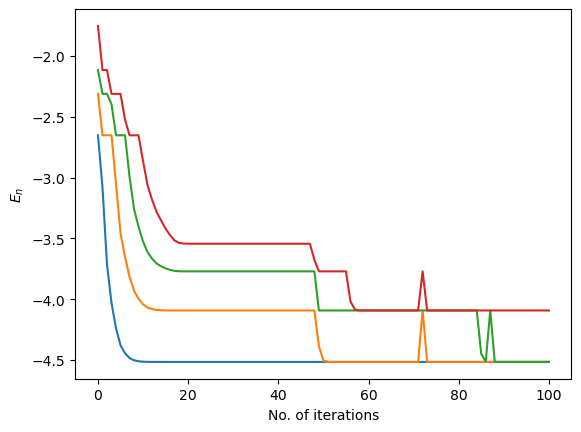

In [23]:
if __name__ == '__main__':
    L = 10
    W, V, X, Y, Y1, Y2, Y3 = main(L, 1)
    plt.plot(X, Y)
    plt.plot(X, Y1)
    plt.plot(X, Y2)
    plt.plot(X, Y3)
    plt.xlabel("No. of iterations")
    plt.ylabel("$E_n$")
    efull=full_ED(L, 1, 1/2)
    print("Groundstate energy per spin using lanczos ED is,",W.min()/L)
    print("Groundstate energy per spin using full ED is,", efull[0])
    

# Correlation function, $\mathcal{C}_r$

* Since full spectrum is never accurate in lanczos method, we therefore calculate the observables in the groundstate which is relevant to low-temperature physics.
### Diagonal-operators case:
    * For the diagonal operators such as diagonal-diagonal correlation function, the correlation function can be given as:
\begin{equation}\mathcal{C}^i_r =  \langle S^z_iS^z_{i+r}\rangle\quad \text{(At a reference site 'i', we will do this)} \end{equation} 
                                                    (OR) 
\begin{equation}\mathcal{C}_r = \frac{1}{L}\sum\limits_i \mathcal{C}^i_r \quad \text{(Average over all reference sites)}    \end{equation}
    
    * If W and V are the corresponding eigen value and eigen vector matrices. Then practically the calculation of $\langle S^z_i S^z_j\rangle = \langle V[0,:]|S^z_i S^z_j|V[0,:]\rangle \sim \langle V[0,:]| S^z_i S^z_j \bigg(a|0000\rangle + b|0001\rangle + ... \bigg) \sim (-1\times-1)a^2 + \ldots$.

# Correlation function calculation

Let us Calculate and plot the correlation function as a function of 'r'. 

In [24]:
def corr_func(L, ev0):
    basis, nred = mag_basis(L, L/2)
    C = np.zeros(int(L/2), dtype=np.float64) 
    R = [i+1 for i in range(int(L/2))]
    M = len(ev0)
    for a in range(0,M):
        ii = basis[a]
        for r in range(1,int(L/2)+1):
                i = 0;
            #for i in range(0,L):
                j = (i+r)%L
                if IBITS(ii,i) == IBITS(ii,j):
                    C[r-1] += (-1**(r))*(r)*ev0[a]**2
                else:     
                    C[r-1] -= (-1**(r))*(r)*ev0[a]**2
    C /= 4
    return C,R

[0.01901102 0.08041432 0.05774818 0.09346913 0.22008894 0.43487715
 0.20721434 0.39080977] [1, 2, 3, 4, 5, 6, 7, 8]


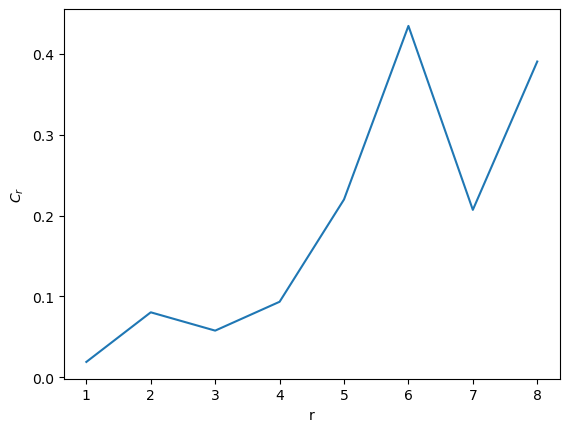

In [25]:
L = 16
C,R=corr_func(L,V[:,0])
print(abs(C),R)
plt.plot(R, abs(C))
plt.xlabel('r')
plt.ylabel("$C_r$")
plt.show()